<a href="https://colab.research.google.com/github/Chang365/ESAA-25-1-assignments/blob/main/ESAA_25_2_0908_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# chp.7 앙상블 학습과 랜덤 포레스트

- 대중의 지혜
- 앙상블로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측 얻음 -> 앙상블 학습
- 앙상블 방법: 앙상블 학습 알고리즘
- 랜덤 포레스트: 결정 트리의 앙상블
- 배깅, 부스팅, 스태킹 등




## 7.1 투표 기반 분류기

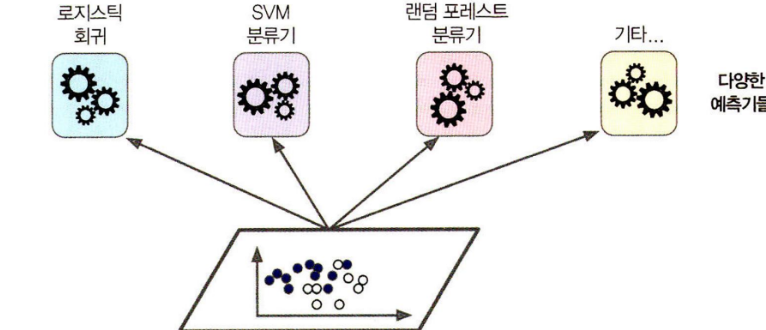

- 직접투표: 다수결 투표로 정해지는 분류기

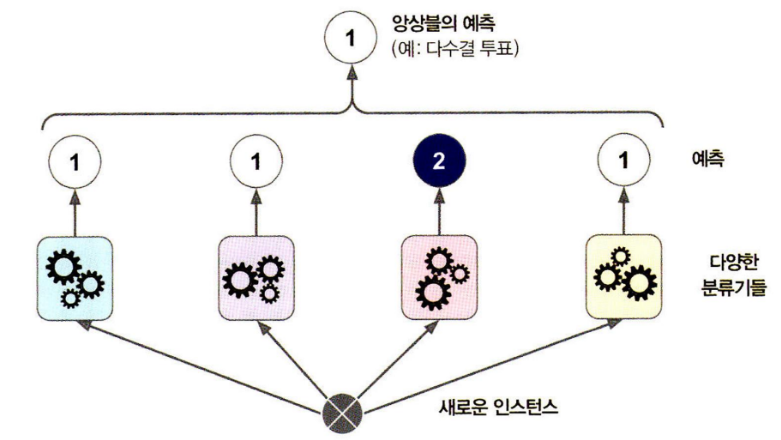

- 분류기가 약한 학습기라도 앙상블은 강한 학습기가 될 수 있음
-> 큰 수의 법칙

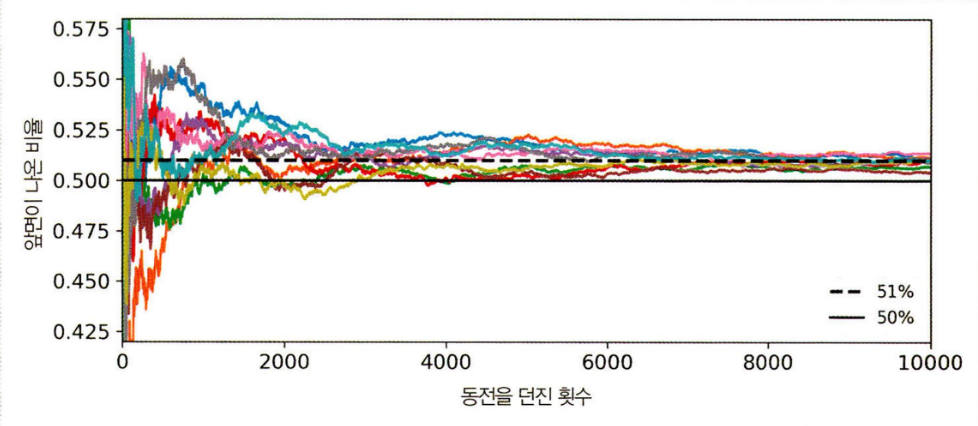

- 하지만 이런 과정은 완벽하게 독립적이고 오차에 상관관계가 없어야 가능


In [5]:
import warnings
warnings.filterwarnings('ignore')

#5장에서 소개한 moons dataset 불러오기

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [7]:
# 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


-> 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음
- 간접투표: 모든 분류기가 클래스의 확률을 예측할 수 있으면 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있음 (직접투표보다 성능이 높음)

## 7.2 배깅과 페이스팅

- 배깅: 훈련세트에서 중복을 허용하여 샘플링하는 방식
- 페이스팅: 중복 허용 X

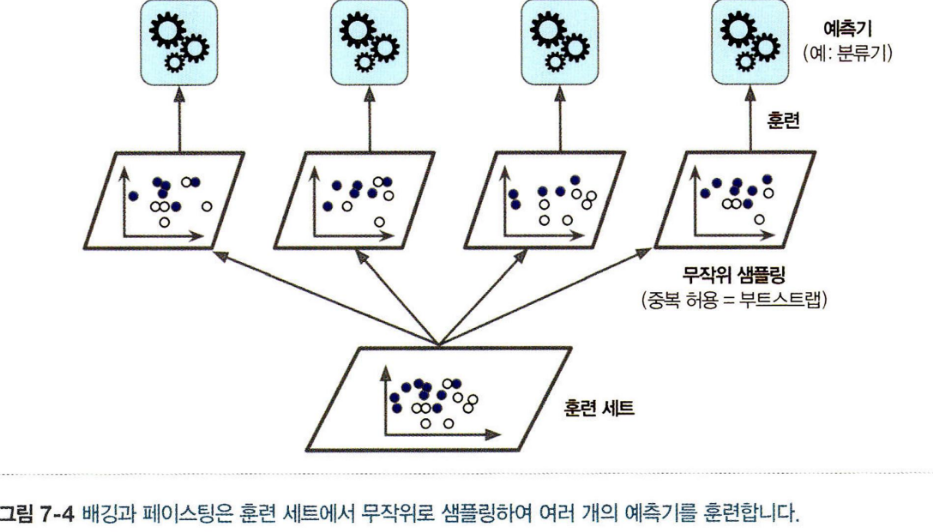![image.png]()

- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦
- 수집함수가 분류일때는 *통계적 최반값*, 회귀에 대해서는 *평균* 계산
- 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집함수를 통과하면 평향과 분산이 모두 감소
- 앙상블 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산이 줄어듦
- 병렬로 학습 가능 -> 인기 많음

### 7.2.1 사이킷런의 배깅과 페이스팅

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

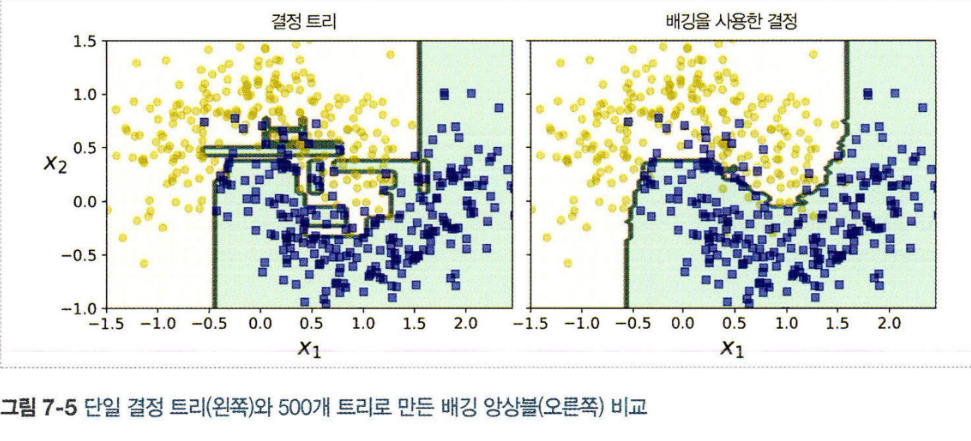

- 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 잘 굄
- 앙상블은 비슷한 편향에서 더 작은 분산을 만듦
- 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 높음
- 다양성 추가 -> 예측기의 상관관계 줄임 -> 앙상블의 분산 감소
- 배깅 을 더 선호

### 7.2.2 oob 평가

- 배깅을 사용하면 어떤 샘플은 여러번 샘플링, 어떤 것은 아예 선택 X -> 선택되지 않은 훈련 샘플의 나머지 37% 를 oob 샘플
- 앙상블 평가는 각 예측기의 oob 평가를 평균하여 얻음

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9375

In [10]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

In [11]:
# oob 샘플에 대한 결정 함수의 값은 oob_decision_function_ 변수에서 확인할 수 있음.
# 이 경우 결정 함수는 각 훈련 샘플의 클래스 확률을 반환.

bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [0.39344262, 0.60655738],
       [0.40116279, 0.59883721],
       [0.10050251, 0.89949749],
       [0.125     , 0.875     ],
       [0.01744186, 0.98255814],
       [1.        , 0.        ],
       [0.75935829, 0.24064171],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.99450549, 0.00549451],
       [0.        , 1.        ],
       [0.92972973, 0.07027027],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.99468085, 0.00531915],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.82010582, 0.17989418],
       [0.99444444, 0.00555556],
       [0.62254902, 0.37745098],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.74056604, 0.25943396],
       [0.14204545, 0.85795455],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.

## 7.3 랜덤 패치와 랜덤 서브스페이스

- 샘플링은 max_features, bootstrap_features 두 매개변수로 조절
- 매우 고차원의 데이터셋 다룸
- 훈련 특성과 샘플을 모두 샘플링하는 것을 랜덤 패치 방식이라고 함
- 훈련샘플을 모두 사용하고 특성을 샘플링하는 것을 랜덤서브스페이스 방식이라고 함
- 펴냥을 늘리는 대신 분산을 낮춤

## 7.4 랜덤 포레스트

- max_samples를 훈련 세트의 크기로 지정
- RandomForestClassifier 사용

In [12]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

- 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입


In [13]:
# BaggingClassifier로 RandomForestClassifier랑 유사하게 만들기

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

### 7.4.1 엑스트라 트리

- 익스트림 랜덤 트리, 엑스트라 트리
: 극단적으로 무작위한 트리의 랜덤 포레스트
- 랜덤 포레스트보다 빠름
- ExtraTreesClassifier 사용

### 7.4.2 특성 중요도

- 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정
- 중요도의 전체 합이 1이 되도록 결괏값을 정규와

In [14]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs = -1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.0999885593508831
sepal width (cm) 0.0241633401142744
petal length (cm) 0.41905097552847764
petal width (cm) 0.4567971250063648
